## (1) BALANCING METHODS

### 1.1 Resampling Techniques

##### Under-sampling
 1. Random Undersampling
 2. Neighbourhood Cleaning Rule
 3. One Sided Selection

##### Over-sampling
 4. SMOTE (Synthetic Minority Oversampling Technique)
 5. ADASYN
 6. BorderSMOTE

##### Hybrid-sampling
 7. SMOTE + ENN
 8. SMOTE + Tomek links

----------------------------------------
## (2) CLASSIFIERS
- Logit
- Random Forest
- Support Vector Machines (SVM)
- XGBoost

# 1. IMPORT AND PREPROCESS DATA

### Import data (one hot encoding)

In [1]:
import numpy as np
import pandas as pd

# Import data
df = pd.read_csv('all_data_onehot_dwe.csv')
# select dependent variable
df = df.drop(columns = ['excluded', 'withdraw'])
# Make X and y
y = df.iloc[:,0]
X = df.iloc[:, 1:]
# summary of data
print('num of observations:', len(df))
print('Dependent variable :', df.columns.values[0])

num of observations: 878540
Dependent variable : dropout


#### ~Subset data by institution type UNI, CFT or IP

### Class distribution in dataset

In [2]:
from collections import Counter

# summarize class distribution
counter = Counter(y)
print(counter)
print('ratio: 1.0 drop to', round(counter[0]/counter[1], 1), 'stay')
skew_pn = counter[1]/counter[0]
print('ratio:', round(skew_pn, 1), 'drop to 1.0 stay')
AUCPRmin = 1+((1-skew_pn)*np.log(1-skew_pn)/skew_pn)
print('AUC PR min:', round(AUCPRmin, 3))

Counter({0: 666372, 1: 212168})
ratio: 1.0 drop to 3.1 stay
ratio: 0.3 drop to 1.0 stay
AUC PR min: 0.179


### Make toy dataset to test

### Split into train and test sets

### Standardize data

# 3. BENCHMARKING RESAMPLING METHODS WITH CROSS VALIDATION

## 3.1 PIPELINE OF RESAMPLING METHODS

In [3]:
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule, OneSidedSelection, NearMiss
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# Define Samplers to balance data
rdm_state = 123
samplers = [
    ['Unbalanced', 'passthrough'],
    ['RUS', RandomUnderSampler(random_state=rdm_state)],
    ['NCR', NeighbourhoodCleaningRule()],
    ['OSS', OneSidedSelection(random_state=rdm_state)],
    ['SMOTE', SMOTE(random_state=rdm_state)],
    ['ADASYN', ADASYN(random_state=rdm_state)],
    ['BorderSMOTE', BorderlineSMOTE(random_state=rdm_state)],
    ['SMOTE+ENN', SMOTEENN(random_state=rdm_state)],
    ['SMOTE+Tomek', SMOTETomek(random_state=rdm_state)],
]

## 3.2 FUNCTION BENCHMARKING WITH CROSS VALIDATION

In [4]:
# Function V2.0 With a Threshold of 0.5
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, fbeta_score
from sklearn.metrics import make_scorer, confusion_matrix, average_precision_score
from imblearn.pipeline import Pipeline, make_pipeline

def bm_resampling():
    # Define a pipeline
    pipelines = [['{}'.format(sampler[0]), make_pipeline(sampler[1], classifier[1])] for sampler in samplers]
    # dict for scores
    metrics = ['acc', 'auc_pr', 'auc_roc', 'f1_score', 'f2_score', 'precision', 'recall']
    metrics_std = ['acc_sd', 'aucpr_sd', 'aucroc_sd', 'f1_sd', 'f2_sd', 'preci_sd', 'recall_sd']
    scores = {key: np.empty(0) for key in metrics}
    metrics.extend(metrics_std)
    avg_scores = {key: np.empty(0) for key in metrics}
    prob_dict = {}
    # Fit models 
    cv = StratifiedKFold(n_splits=5, shuffle= True, random_state=42)
    for name, pipeline in pipelines:
        print('fitting:', name)
        all_probs = np.zeros(len(X)) # array to store probabilities for PR plot
        # Cross Validation
        for train, test in cv.split(X, y):
            fit_model = pipeline.fit(X.iloc[train], y.iloc[train])
            # calculate metrics curves
            y_true = y.iloc[test]
            probs = pipeline.predict_proba(X.iloc[test])[:,1]
            all_probs[test] = probs
            precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
            pr_auc = auc(recalls, precisions)
            fpr, tpr, thresholds_roc = roc_curve(y_true, probs)
            roc_auc = auc(fpr, tpr)
            # calculate metrics threshold 0.5
            y_pred = pipeline.predict(X.iloc[test])
            tpr = recall_score(y_true, y_pred)
            acc = accuracy_score(y_true, y_pred)
            ppv = precision_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            f2 = fbeta_score(y_true, y_pred, beta=2)
            avg_pre = average_precision_score(y_true, y_pred)
            # save list with metrics
            score_lst = [acc, pr_auc, roc_auc, f1, f2, ppv, tpr]
            for metric, score in zip(scores, score_lst):
                scores[metric] = np.append(scores[metric], score)
        for metric, std in zip(scores, metrics_std):
            avg_scores[metric] = np.append(avg_scores[metric], scores[metric].mean())
            avg_scores[std] = np.append(avg_scores[std], scores[metric].std())
        prob_dict[name] = all_probs
    # Print results
    df = pd.DataFrame(data=avg_scores, index=[k[0] for k in samplers])
    return df, prob_dict

## 3.3 FUNCTION PLOT PR-CURVE AND ROC-CURVE

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve, roc_curve

def plot_bm_resampling(prob_dict):
    # plot figures
    fig = plt.figure(figsize=(9, 4), dpi=100, facecolor='w')
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    for model in prob_dict:
        # metrics
        precision, recall, thresholds = precision_recall_curve(y, prob_dict[model])
        fpr, tpr, thresholds1 = roc_curve(y, prob_dict[model])
        pr_auc_ = auc(recall, precision)
        roc_auc_ = auc(fpr, tpr)
        # plot the PR Curve
        ax1.plot(recall, precision, linestyle='-', linewidth=1, alpha=0.5,
                 label='{} (auc: %0.2f)'.format(model) % pr_auc_)
        # plot the ROC Curve
        ax2.plot(fpr, tpr, linestyle='--', linewidth=2, alpha=0.5,
                 label='{} (auc: %0.2f)'.format(model) % roc_auc_)
    # PR Curve plot attributes
    no_skill = len(y[y==1]) / len(y)
    ax1.plot([0,1], [no_skill,no_skill], linestyle='--', label=None, lw=1, c='grey')
    ax1.set_title('Precision-Recall Curve')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.legend(loc="upper right", fontsize=8)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    # ROC Curve plot attributes
    ax2.plot([0,1], [0,1], linestyle='--', label=None, lw=1, c='grey')
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('Recall (TP Rate)')
    ax2.legend(loc="lower right", fontsize=8)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    # show plot
    plt.show()

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve, roc_curve

def plot_pr_curve(prob_dict):
    # plot figures
    fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='w')
    ax1 = fig.add_subplot()
    for model in prob_dict:
        # metrics
        precision, recall, thresholds = precision_recall_curve(y, prob_dict[model])
        pr_auc_ = auc(recall, precision)
        # plot the PR Curve
        ax1.plot(recall, precision, linestyle='-', linewidth=1, alpha=0.5,
                 label='{} (auc: %0.2f)'.format(model) % pr_auc_)
    # PR Curve plot attributes
    no_skill = len(y[y==1]) / len(y)
    ax1.plot([0,1], [no_skill,no_skill], linestyle='--', label=None, lw=1, c='grey')
    ax1.set_title('Precision-Recall Curve')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.legend(loc="lower right", fontsize=8)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    # show plot
    plt.show()

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve, roc_curve

def plot_roc_curve(prob_dict):
    # plot figures
    fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='w')
    ax2 = fig.add_subplot()

    for model in prob_dict:
        # metrics
        fpr, tpr, thresholds1 = roc_curve(y, prob_dict[model])
        roc_auc_ = auc(fpr, tpr)
        # plot the ROC Curve
        ax2.plot(fpr, tpr, linestyle='--', linewidth=2, alpha=0.5,
                 label='{} (auc: %0.2f)'.format(model) % roc_auc_)
    # ROC Curve plot attributes
    ax2.plot([0,1], [0,1], linestyle='--', label=None, lw=1, c='grey')
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('Recall (TP Rate)')
    ax2.legend(loc="lower right", fontsize=8)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    # show plot
    plt.show()

# 4. RUN FUNCTIONS WITH CLASSIFIERS

## 4.1 RANDOM FOREST

fitting: Unbalanced
fitting: RUS
fitting: NCR
fitting: OSS
fitting: SMOTE
fitting: ADASYN
fitting: BorderSMOTE
fitting: SMOTE+ENN
fitting: SMOTE+Tomek


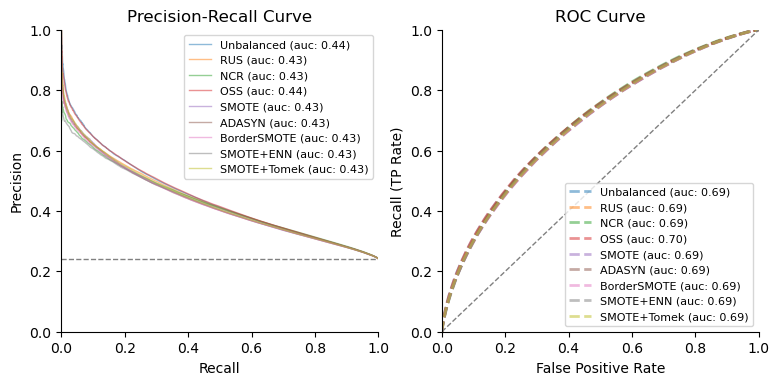

,acc,auc_pr,auc_roc,f1_score,f2_score,precision,recall,acc_sd,aucpr_sd,aucroc_sd,f1_sd,f2_sd,preci_sd,recall_sd
Unbalanced,0.770766,0.441575,0.694536,0.244743,0.180649,0.598910,0.153798,0.000446,0.001665,0.000490,0.001843,0.001508,0.003785,0.001342
RUS,0.712823,0.437644,0.694148,0.353018,0.360922,0.484555,0.382824,0.057949,0.004208,0.000741,0.108284,0.180278,0.114388,0.229032
NCR,0.713330,0.434969,0.694345,0.383680,0.394642,0.462768,0.413287,0.047322,0.005182,0.000772,0.098478,0.154732,0.098351,0.191907
OSS,0.727355,0.436760,0.694792,0.363243,0.355072,0.487464,0.361584,0.047641,0.005514,0.001053,0.092343,0.150513,0.095320,0.188790
SMOTE,0.735078,0.435275,0.693466,0.350947,0.331783,0.497942,0.331150,0.045325,0.005799,0.002819,0.086182,0.142456,0.087799,0.179496
ADASYN,0.740193,0.433955,0.692505,0.341701,0.315210,0.504948,0.309855,0.042928,0.006086,0.003361,0.081348,0.135223,0.081667,0.170636
BorderSMOTE,0.743826,0.432934,0.691842,0.335491,0.303788,0.509745,0.295051,0.040728,0.006197,0.003521,0.076840,0.128284,0.076524,0.162090
SMOTE+ENN,0.739871,0.432035,0.691818,0.348934,0.323453,0.498011,0.317419,0.039510,0.006281,0.003303,0.080198,0.130795,0.078026,0.162766
SMOTE+Tomek,0.742819,0.431892,0.691593,0.344021,0.314331,0.502878,0.305703,0.038172,0.005954,0.003193,0.076879,0.125986,0.074843,0.156995


In [8]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
classifier = ['R.Forest', RandomForestClassifier(n_estimators=300, min_samples_split=2, random_state=123)]
df_all_rfo, probs_all_rfo = bm_resampling()
plot_bm_resampling(probs_all_rfo)
df_all_rfo

In [9]:
# Save results
import pickle
pickle.dump(probs_all_rfo, open( "results_prob_dict_alldata_rfo.p", "wb" ) )
pickle.dump(df_all_rfo, open( "results_df_alldata_rfo.p", "wb" ) )

## 4.2 LOGISTIC REGRESSION

fitting: Unbalanced
fitting: RUS
fitting: NCR
fitting: OSS
fitting: SMOTE
fitting: ADASYN
fitting: BorderSMOTE
fitting: SMOTE+ENN
fitting: SMOTE+Tomek


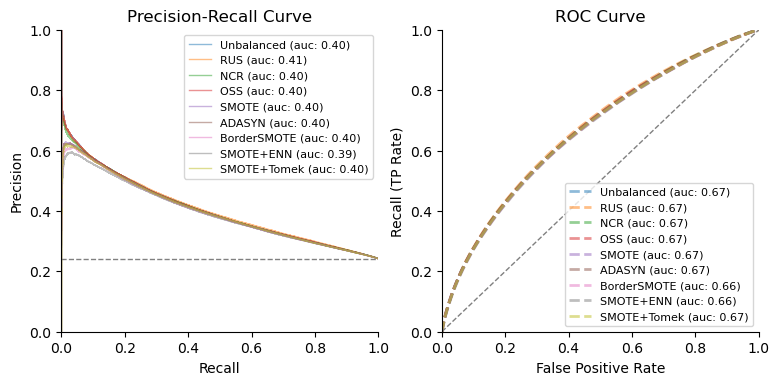

,acc,auc_pr,auc_roc,f1_score,f2_score,precision,recall,acc_sd,aucpr_sd,aucroc_sd,f1_sd,f2_sd,preci_sd,recall_sd
Unbalanced,0.764496,0.404417,0.668641,0.147063,0.101468,0.586660,0.084089,0.000471,0.004084,0.003851,0.005593,0.004257,0.006560,0.003655
RUS,0.705375,0.405370,0.670350,0.295792,0.310673,0.472348,0.335107,0.059124,0.003277,0.003736,0.148793,0.209249,0.114408,0.251072
NCR,0.709461,0.404579,0.669654,0.333856,0.343025,0.452861,0.358826,0.048640,0.003016,0.003291,0.132888,0.176895,0.097413,0.207763
OSS,0.723272,0.404466,0.669346,0.302185,0.294922,0.478677,0.300976,0.048442,0.003412,0.003566,0.127631,0.174462,0.095492,0.205998
SMOTE,0.731498,0.403496,0.668680,0.279102,0.262628,0.495218,0.263205,0.046347,0.004479,0.003871,0.123231,0.168928,0.091628,0.199165
ADASYN,0.736982,0.402753,0.668141,0.261288,0.239105,0.507379,0.236262,0.044051,0.005131,0.004172,0.119415,0.162967,0.087980,0.191555
BorderSMOTE,0.740874,0.401858,0.667528,0.249124,0.222766,0.515461,0.217427,0.041884,0.006088,0.004880,0.114547,0.156117,0.083868,0.183262
SMOTE+ENN,0.738022,0.400777,0.666948,0.268295,0.244535,0.502552,0.239412,0.039922,0.007557,0.006014,0.118606,0.157037,0.085622,0.181079
SMOTE+Tomek,0.740936,0.400556,0.666829,0.259295,0.232247,0.508849,0.225318,0.038531,0.007351,0.005834,0.114730,0.152104,0.082674,0.175332


In [10]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier = ['Logit', LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000)]
df_all_log, probs_all_log = bm_resampling()
plot_bm_resampling(probs_all_log)
df_all_log

In [11]:
# Save results
import pickle
pickle.dump(probs_all_log, open( "results_prob_dict_alldata_log.p", "wb" ) )
pickle.dump(df_all_log, open( "results_df_alldata_log.p", "wb" ) )

## 4.3 XGBOOST

fitting: Unbalanced
fitting: RUS
fitting: NCR
fitting: OSS
fitting: SMOTE
fitting: ADASYN
fitting: BorderSMOTE
fitting: SMOTE+ENN
fitting: SMOTE+Tomek


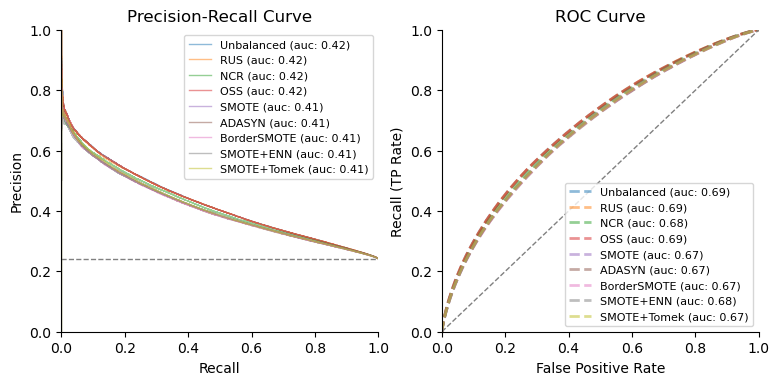

,acc,auc_pr,auc_roc,f1_score,f2_score,precision,recall,acc_sd,aucpr_sd,aucroc_sd,f1_sd,f2_sd,preci_sd,recall_sd
Unbalanced,0.767378,0.424978,0.685814,0.184724,0.130490,0.601325,0.109130,0.000414,0.001701,0.000742,0.003026,0.002416,0.005250,0.002114
RUS,0.718753,0.424618,0.685843,0.318883,0.322503,0.489568,0.337412,0.048631,0.001722,0.000718,0.134176,0.192023,0.111820,0.228292
NCR,0.719770,0.421863,0.683891,0.353229,0.355336,0.467534,0.365072,0.039736,0.004244,0.002848,0.119845,0.163524,0.096476,0.190468
OSS,0.731716,0.422585,0.684315,0.326737,0.312686,0.492474,0.313326,0.040155,0.003986,0.002594,0.113490,0.159730,0.094094,0.187731
SMOTE,0.738109,0.420101,0.682015,0.315519,0.291970,0.500260,0.286976,0.038125,0.006175,0.005159,0.103979,0.148767,0.085603,0.175997
ADASYN,0.742477,0.418157,0.680231,0.304368,0.274616,0.506942,0.266070,0.036148,0.007149,0.006175,0.098203,0.141277,0.079576,0.167353
BorderSMOTE,0.745403,0.416743,0.679097,0.299035,0.264820,0.509841,0.253604,0.034226,0.007492,0.006360,0.091863,0.132987,0.074023,0.157924
SMOTE+ENN,0.738412,0.415821,0.678627,0.316066,0.290411,0.494624,0.283851,0.036980,0.007445,0.006083,0.097029,0.141639,0.080097,0.168023
SMOTE+Tomek,0.741157,0.415299,0.678099,0.311869,0.282247,0.498182,0.273326,0.035720,0.007194,0.005929,0.092253,0.135524,0.076196,0.161189


In [12]:
from xgboost import XGBClassifier

# XGBoost
classifier = ['XGBoost', XGBClassifier(random_state=123)]
df_all_xgb, probs_all_xgb = bm_resampling()
plot_bm_resampling(probs_all_xgb)
df_all_xgb

In [13]:
# Save results
import pickle
pickle.dump(probs_all_xgb, open( "results_prob_dict_alldata_xgb.p", "wb" ) )
pickle.dump(df_all_xgb, open( "results_df_alldata_xgb.p", "wb" ) )

## 4.4 SVM

# PLOTTIN BEST MODELS

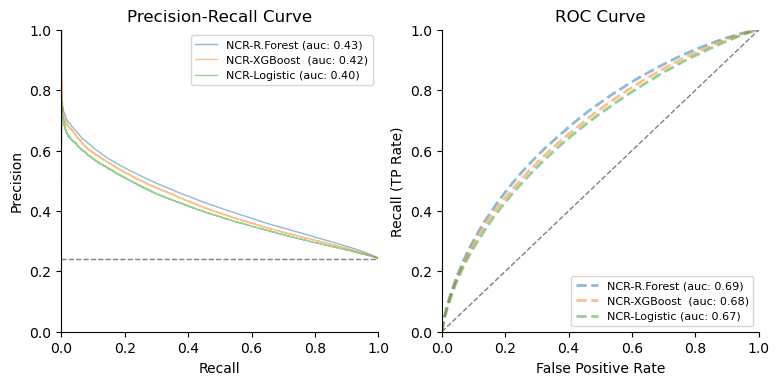

In [14]:
probs_final = {'NCR-R.Forest': probs_all_rfo['NCR'],
               'NCR-XGBoost ': probs_all_xgb['NCR'],
               'NCR-Logistic': probs_all_log['NCR'],
              }
plot_bm_resampling(probs_final)

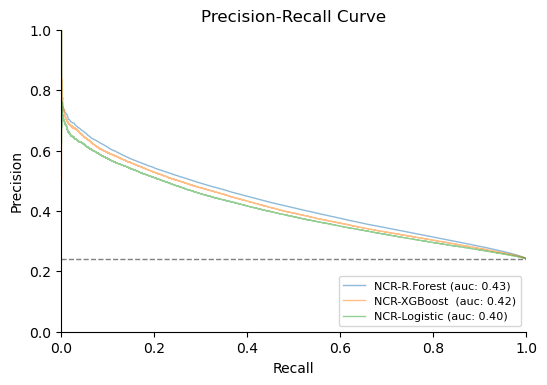

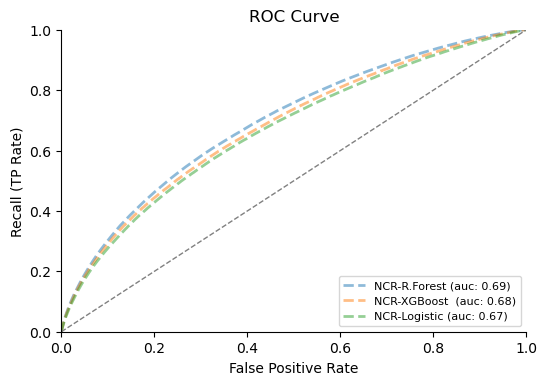

In [15]:
plot_pr_curve(probs_final)
plot_roc_curve(probs_final)

# PERMUTATION FEATURE IMPORTANCE

### Import data (categorical)

In [1]:
import numpy as np
import pandas as pd

# Import data
df1 = pd.read_csv('all_data_categorical_dwe.csv')
# select dependent variable
df1 = df1.drop(columns = ['excluded', 'withdraw'])
# Make X and y
y = df1.iloc[:,0]
X = df1.iloc[:, 1:]
# summary of data
print('num of observations:', len(df1))
print('Dependent variable :', df1.columns.values[0])

num of observations: 878540
Dependent variable : dropout


### Make toy dataset to test

### Split into train and test sets

In [2]:
from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = \
train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (702832, 25) (702832,)
Test (175708, 25) (175708,)


## Random Forest

In [3]:
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule
from sklearn.ensemble import RandomForestClassifier

# Make pipeline
onehot = OneHotEncoder(handle_unknown='ignore')
resample = NeighbourhoodCleaningRule()
clf = RandomForestClassifier(n_estimators=300, random_state=123)
pipeline = Pipeline([('onehot', onehot), ('resample', resample), ('clf', clf)])
# fit pipeline and predict
fit_model = pipeline.fit(X_train, y_train)
imp = permutation_importance(fit_model, X_test, y_test, n_repeats=10, scoring='f1', random_state=42)
# Save results
import pickle
pickle.dump(imp, open( "feature_importance_all_data_NCR_Rforest.p", "wb" ) )

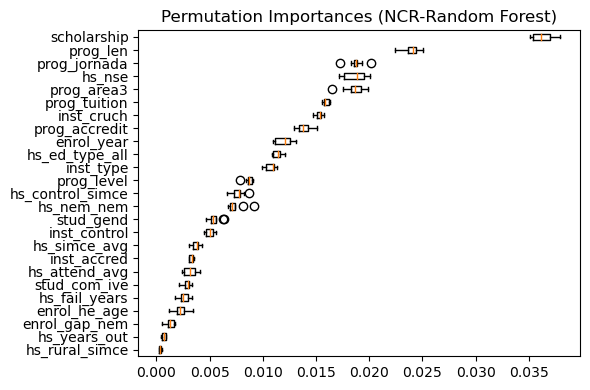

In [4]:
import matplotlib.pyplot as plt

# Plot Permutation importances
sorted_idx = imp.importances_mean.argsort()
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='w')
ax = fig.add_subplot()
#fig, ax = plt.subplots()
ax.boxplot(imp.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (NCR-Random Forest)")
fig.tight_layout()
plt.show()

In [5]:
for i in imp.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns.values[i]:}"
          f"\t\t"
          f"{imp.importances_mean[i]:.3f}"
          f" +/- {imp.importances_std[i]:.3f}")

scholarship		0.036 +/- 0.001
prog_len		0.024 +/- 0.001
prog_jornada		0.019 +/- 0.001
hs_nse		0.019 +/- 0.001
prog_area3		0.019 +/- 0.001
prog_tuition		0.016 +/- 0.000
inst_cruch		0.015 +/- 0.000
prog_accredit		0.014 +/- 0.001
enrol_year		0.012 +/- 0.001
hs_ed_type_all		0.011 +/- 0.000
inst_type		0.011 +/- 0.000
prog_level		0.009 +/- 0.000
hs_control_simce		0.008 +/- 0.001
hs_nem_nem		0.007 +/- 0.001
stud_gend		0.005 +/- 0.001
inst_control		0.005 +/- 0.000
hs_simce_avg		0.004 +/- 0.000
inst_accred		0.003 +/- 0.000
hs_attend_avg		0.003 +/- 0.001
stud_com_ive		0.003 +/- 0.000
hs_fail_years		0.003 +/- 0.000
enrol_he_age		0.002 +/- 0.001
enrol_gap_nem		0.001 +/- 0.000
hs_years_out		0.001 +/- 0.000
hs_rural_simce		0.000 +/- 0.000


## XGBoost

## ------------------------------------------------------------

# 5. RUN FUNCTIONS WITH UNI DATA

## Subset data by institution type UNI

## 5.1 RANDOM FOREST

# 6. RUN FUNCTIONS WITH IP & CFT DATA

## Subset data by institution type CFT & IP

## 6.1 RANDOM FOREST

# FUNCTION TO DO BENCHMARK RESAMPLING METHODS

## Function with Both Curves

### Logit

### XGBoost

### Random Forest

# TUNNING RESAMPLING METHODS

## Function only with ROC Curve

## Function only with PR Curve

# ~DISASTER

# RESAMPLING AND CLASSIFYING 1 by 1

## 3.1 LOGISTIC REGRESSION

## RANDOM FOREST

### Random Forest  in imbalanced data

### Random Forest in data balanced with ADASYN

### Random Forest in data balanced with SMOTE + ENN

### Random Forest in data balanced with SMOTE + Tomek

## XGBoost with Holdout

### XGBoost in imbalanced data

### XGBoost in data balanced with SMOTE

### XGBoost in data balanced with SMOTE + ENN

### XGBoost in data balanced with SMOTE + Tomek

# TUNNING USING GRID SEARCH WITH CV

## Tunning with Resampler and Classifier

### Random Forest  tunning

### XGBoost tunning

## Tunning grid search wrapper

# New attempt at Cross Validation (12/08/2020)

## nueva funcion con probabilidad

# CROSS VALIDATION

## Cross Validation - Random Forest

### Random Forest with CV in imbalanced data

### Random Forest with CV in data balanced with SMOTE

### Random Forest with CV in data balanced with SMOTE+ENN

## Cross Validation - SVM

## Cross Validation - XGBoost

# 2. BALANCE DATASETS

### a. SMOTE

### b. SMOTE + ENN

### c. SMOTE + Tomek Links

# Function to evaluate results

### 3.2 Old function for benchmarking with cross-validation SELECTING THRESHOLD

# FEATURE SELECTION

### Recursive feature elimination with cross-validation
the results gave 64 out of 65 variables as the optimum

### Feature selection too

# Functions to get F1 and F2 scores